# **Probability of Default(PD)**
## **Credit Risk Modeling Sample**  (estimated completion date: 08/03/2024)

#### **Developed by**: Bin Acharya
#### **Version**:  Version 1
#### **Git Tag**:
#### **Date**: 07/30/2024

#### **Revision History**:
    - Version 1: Estimated completion date 08/03/2024
    - Version 2: Pending.... Milestione 08/10/2024
                 Calculate Unexpected Loss and Financial Impact
                 Work on visualizing feature analysis Section 






## Purpose
    * Predict Probability of Default for loans using Logistic Regression and XGBoost


## References:
    * OCC: https://www.occ.treas.gov/news-issuances/bulletins/2011/bulletin-2011-12a.pdf
         : https://www.occ.treas.gov/publications-and-resources/publications/comptrollers-handbook/files/model-risk-management/pub-ch-model-risk.pdf
         : https://www.occ.treas.gov/publications-and-resources/publications/comptrollers-handbook/files/allowances-for-credit-losses/index-allowance-credit-losses.html
    * CECL: https://www.federalreserve.gov/econres/feds/files/2023063pap.pdf
    * Book: https://books.google.com/books/about/Measuring_and_Managing_Credit_Risk.html

 --------------------------------

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, train_test_split, cross_val_score
from sklearn.feature_selection import RFECV, RFE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve

from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


print("Libraries Imported")

Libraries Imported


## Model Data


"To measure risk effectively, the data inputs for models should be reliable. Banks ordinarily document the major data sources used in the risk measurement process. Sound risk management involves providing reasonable and reconcilable support for qualitative factors used to account for environmental differences between quantitative estimates and current market and economic conditions."
###### - OCC: Model Risk Management, Comptroller's Handbook 2021

### Data Requirements

Before development stage, begin with what is the purpose of the model and what it will be used for. Simply put, "What question are we trying to answer?" and business objectives. Conduct research to understand the literary concepts and the mathematical techniques used for predicting the model. Next, identify and understand the dependent variable in the model and the factors that will influence it. Then set up data requirements. 

### Data Sources

Once the requirements are set up for the data that is needed, look for data sources that are appropriate. The conduct appropriate best practices to obtain the data. In enterprise level, this includes approval from various data management teams, and detailed description of calulated fields and data dictionaries.


#### Source: Lending Tree Data

In [2]:
loan_data = pd.read_csv('input_data/loan_data_2007_2014.csv', index_col= [0])
display(loan_data.iloc[:5, :12])
line = '----------------------------------------------------------------------'
print("Number of Columns: {c} \
       \nNumber of Rows:    {r}".format(c= len(loan_data.columns), r= len(loan_data)))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year


Number of Columns: 74        
Number of Rows:    466285


In [3]:
# pd.set_option('display.max_rows',100)

## Model Data Preprocessing

### Dependent Variable Definition

Dependent Variable must be defined clearly.

-------------------------

The dependent variable is Default, an indicator that equals one if a loan defaults (i.e., becomes 90 days past due) within four quarters of the reporting quarter.

###### - Federal Reserve: Current Expected Credit Losses (CECL) Standard and Banks’ Information Production 2023

-------------------------

**Dependent Variable**

 -  loan_status column is used to create binary default flag
 -  1 is non-default. 0 is default
 -  'Late (31-120 days)' is considered default for this excercise as 90 DPD falls within this period


In [4]:
# Renaming column name 'loan_status' will be used for binary flag
loan_data.rename(columns= {'loan_status':'loan_status_type'}, inplace= True)
reorder_list = ['Current', 'Fully Paid', 'Late (16-30 days)', 'In Grace Period', 
                'Does not meet the credit policy. Status:Fully Paid', 'Default', 
                'Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']
# display(loan_data['loan_status_type'].value_counts(dropna= False).reindex(reorder_list))


# Creating Default Flag
loan_data['loan_status'] = np.where(loan_data['loan_status_type'].isin(['Default', 'Charged Off', 'Late (31-120 days)',
                                                                    'Does not meet the credit policy. Status:Charged Off']),1,0)
print(line,"\n",(loan_data['loan_status'].value_counts()))


---------------------------------------------------------------------- 
 loan_status
0    415317
1     50968
Name: count, dtype: int64


--------------------------

### Missing Data Imputation

In [5]:
def miss_data_percent(dataset, percent_int, cap_or_floor):
    ''' 
    ----------------------------------------------------------------------
    dataset = Data to check missing values (eg: loan_data)
    percent_int = Any number value (eg:50, 75, 90)
    cap_or_floor = Caps or floors percent_int input. Type 'cap' or 'floor'
    ----------------------------------------------------------------------
    '''
    miss_data_perc = dataset.isnull().sum() /len(dataset) 
    if cap_or_floor == 'cap':
        cols_to_focus = miss_data_perc[miss_data_perc <= int(percent_int)/100]
        cols_to_focus = cols_to_focus[cols_to_focus > 0]
    elif cap_or_floor == 'floor':
         cols_to_focus = miss_data_perc[miss_data_perc >= int(percent_int)/100]    
    cols_to_focus.sort_values(ascending= False, inplace= True)
    return cols_to_focus

#### Over 50% missing data

--------------------------------

In [6]:
print("The following columns will be dropped due to over 50% missing data:\n "
      , line, "\n" , miss_data_percent(loan_data, 50, 'floor').axes)

cols_to_drop = ['open_il_24m', 'mths_since_rcnt_il', 'total_cu_tl', 'inq_fi', 'all_util', 'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'il_util'
                ,'total_bal_il', 'inq_last_12m', 'open_il_12m', 'open_il_6m', 'open_acc_6m', 'verification_status_joint', 'dti_joint'
                ,'annual_inc_joint', 'mths_since_last_record','mths_since_last_major_derog', 'desc', 'mths_since_last_delinq']
loan_data.drop(columns=cols_to_drop, inplace= True)

The following columns will be dropped due to over 50% missing data:
  ---------------------------------------------------------------------- 
 [Index(['open_il_24m', 'mths_since_rcnt_il', 'total_cu_tl', 'inq_fi',
       'all_util', 'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'il_util',
       'total_bal_il', 'inq_last_12m', 'open_il_12m', 'open_il_6m',
       'open_acc_6m', 'verification_status_joint', 'dti_joint',
       'annual_inc_joint', 'mths_since_last_record',
       'mths_since_last_major_derog', 'desc', 'mths_since_last_delinq'],
      dtype='object')]


---------------------------

#### Between 5% and 50% missing data



In [7]:
print("The following columns have data missing between 5% and 50%:\n", line, "\n", miss_data_percent(loan_data, 5, 'floor'))
print(line, "\n",
      "These columns will be dropped. Missing data for these not be imputed for following reasons: \n"
      , "1. Information not available during loan issue (next_pymnt_d, tot_coll_amt,tot_cur_bal,total_rev_hi_lim ) ", "\n"
      , "2. User manually typed Employment titles(emp_title). There are {a} unique employment titles ".format(a= loan_data['emp_title'].nunique()))

cols_to_drop = ['next_pymnt_d', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'emp_title']
loan_data.drop(columns=cols_to_drop, inplace= True)

The following columns have data missing between 5% and 50%:
 ---------------------------------------------------------------------- 
 next_pymnt_d        0.487286
tot_coll_amt        0.150715
tot_cur_bal         0.150715
total_rev_hi_lim    0.150715
emp_title           0.059166
dtype: float64
---------------------------------------------------------------------- 
 These columns will be dropped. Missing data for these not be imputed for following reasons: 
 1. Information not available during loan issue (next_pymnt_d, tot_coll_amt,tot_cur_bal,total_rev_hi_lim )  
 2. User manually typed Employment titles(emp_title). There are 205475 unique employment titles 


---------------------------

#### Less than 5% missing data



In [8]:
miss_data_percent(loan_data,5, 'cap')
display(loan_data.isnull().sum()[loan_data.isnull().sum() > 1].sort_values(ascending= False))

print("The following columns will be dropped: revol_util, collections_12_mths_ex_med, delinq_2yrs, inq_last_6mths, open_acc , total_acc, acc_now_delinq, title, last_pymnt_d, last_credit_pull_d")
cols_to_drop = ['revol_util', 'collections_12_mths_ex_med', 'delinq_2yrs', 'inq_last_6mths', 'open_acc' , 'total_acc', 'acc_now_delinq', 'title','last_pymnt_d','last_credit_pull_d','addr_state']
loan_data.drop(columns=cols_to_drop, inplace= True)

emp_length                    21008
last_pymnt_d                    376
revol_util                      340
collections_12_mths_ex_med      145
last_credit_pull_d               42
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                         29
pub_rec                          29
total_acc                        29
acc_now_delinq                   29
title                            21
annual_inc                        4
dtype: int64

The following columns will be dropped: revol_util, collections_12_mths_ex_med, delinq_2yrs, inq_last_6mths, open_acc , total_acc, acc_now_delinq, title, last_pymnt_d, last_credit_pull_d


-----------------------------

#### Columns to impute missing values

In [9]:
loan_data.isnull().sum()[loan_data.isnull().sum() > 0].sort_values(ascending= False)

emp_length          21008
earliest_cr_line       29
pub_rec                29
annual_inc              4
dtype: int64

In [10]:
# emp_length
mapping_dict = {
    "emp_length": {
        "10+ years": 10, "9 years": 9,  "8 years": 8,
        "7 years": 7,    "6 years": 6,  "5 years": 5,
        "4 years": 4,    "3 years": 3,  "2 years": 2,
        "1 year": 1,     "< 1 year": 0, "n/a": 0
    }
}
loan_data = loan_data.replace(mapping_dict)
loan_data['emp_length'] = np.where(loan_data['emp_length'].isnull(),0, loan_data['emp_length'])


# earliest_cr_line
# After further investigating the 29 missing are loans issued on either Jun,Jul,Aug of 2007. I'll replace issue_d value for these
# When strings are converted to DateTime, 1169 values become 20xx instead of 19xx.
# Since the range for these are from 1948 to 1968. I'll be filling these with the minimum availabe in the dataset. 

loan_data['earliest_cr_line'] = np.where(loan_data['earliest_cr_line'].isnull(), loan_data['issue_d'], loan_data['earliest_cr_line'])
loan_data['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')

loan_data['earliest_cr_line'].describe();
loan_data['earliest_cr_line'][loan_data['earliest_cr_line']  > pd.to_datetime(max(loan_data['issue_d']), format = '%b-%y')].describe();
loan_data['earliest_cr_line'][loan_data['earliest_cr_line']  < pd.to_datetime(max(loan_data['issue_d']), format = '%b-%y')].describe();

loan_data.loc[loan_data['earliest_cr_line'] > pd.to_datetime('2020'), ['earliest_cr_line']] = loan_data['earliest_cr_line'].min()
loan_data['earliest_cr_line'].describe()


# pub_rec
loan_data['pub_rec'] = np.where(loan_data['pub_rec'].isnull(), 0, loan_data['pub_rec'] )

# annual_inc
loan_data['annual_inc'] = np.where(loan_data['annual_inc'].isnull(), loan_data['annual_inc'].mean(), loan_data['annual_inc'] )

--------------------

## Feature Selection and more Pre-processing 
- Delete off columns that are not available when deciding to give the loan
- Unhelpful columns: url, title

### Features not useful

In [11]:
cols_to_drop = ['id', 'sub_grade', 'pymnt_plan', 'url', 'zip_code','policy_code','application_type']
loan_data.drop(columns=cols_to_drop, inplace= True)

# pymnt_plan = all data 'y', zip_code = not number , policy_code = all 1, application_type = all 'INDIVIDUAL', 'sub_grade' = explained by grade
# I will keep 'member id', needed for monitoring data.

### Data not available at Loan Issuance

In [12]:
cols_to_drop = ['revol_bal', 'out_prncp', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp'
                , 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee'
                , 'last_pymnt_amnt', 'out_prncp_inv']
loan_data.drop(columns=cols_to_drop, inplace= True)

### Continuous Variables pre-processing 
#### Variable Dtype, rounding 


In [13]:
loan_data['funded_amnt_inv'] = loan_data['funded_amnt_inv'].astype("int64")
loan_data['int_rate'] = round(loan_data['int_rate'],1)
loan_data['installment'] = loan_data['installment'].astype("int64")
loan_data['emp_length'] = loan_data['emp_length'].astype("int64")
loan_data['annual_inc'] = loan_data['annual_inc'].astype("int64")
loan_data['dti'] = loan_data['dti'].astype("int64")
loan_data['pub_rec'] = loan_data['pub_rec'].astype("int64")
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
loan_data['member_id'] = loan_data['member_id'].astype("str")

### Discrete Variables pre-processing 

In [14]:
# emp_length
mapping_dict = {
    "term": {
        " 36 months": "36_months", 
        " 60 months": "60_months"},
    
    "verification_status":{
        "Verified": "verified", 
        "Source Verified": "source_verified", 
        "Not Verified": "not_verified"}
}
loan_data = loan_data.replace(mapping_dict)

# home_ownership
loan_data['home_ownership'] = np.where(loan_data['home_ownership'].isin(['NONE','ANY']),'OTHER', loan_data['home_ownership'])

----------

## Exploratory Analysis

### Combining info in Issue date and Earliest Credit line Date
My hypothesis is the difference between Issue date and Earliest Credit line Date might be useful feature

In [15]:
loan_data['mths_diff_issu_and_crline'] =  ((loan_data['issue_d']- loan_data['earliest_cr_line']).dt.days / 30.4375)
loan_data['mths_diff_issu_and_crline'] = loan_data['mths_diff_issu_and_crline'].astype("int64")
loan_data.drop(columns=['earliest_cr_line'], inplace= True)

### Features Exploratory Analysis

In [16]:
# loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
#        'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership',
#        'annual_inc', 'verification_status', 'issue_d', 'loan_status_type',
#        'purpose', 'dti', 'pub_rec', 'initial_list_status', 'loan_status',
#        'mths_diff_issu_and_crline'

### Pearson Corrrelation

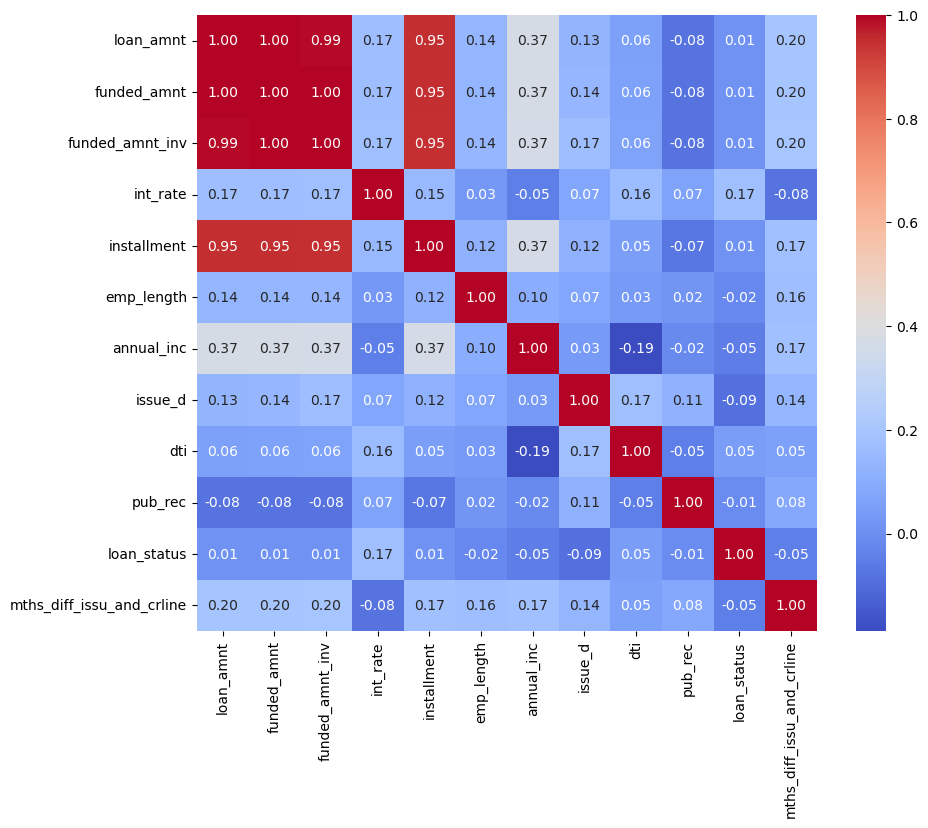

In [17]:
continous_vars = loan_data.select_dtypes(exclude=['object']).columns

fig, ax = plt.subplots(figsize=(10,8))         
cm_df = sns.heatmap(loan_data[continous_vars].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

- loan_amnt vs installment vs funded amount vs funded_amt_inv

In [18]:
loan_data.drop(columns=['funded_amnt', 'funded_amnt_inv','installment'], inplace= True)

### Dummy Variables

In [19]:
cols = ['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status']
for column in cols:
    loan_data[column] = loan_data[column].astype('category')

dummy_df = pd.get_dummies(loan_data[cols], dtype=int)
loan_data = pd.concat([loan_data, dummy_df], axis=1)
loan_data.drop(cols, axis=1, inplace=True)

print(len(loan_data.columns))


43


------------------

## Train Test Split

### Model Monitoring Data
I will be using the final 10% data based off Issue Date for Model Monitoring. The idea is that model is built and tested. Then "pretend" time passes and newly issued loans are being used as monitoring data. 

In [24]:
loan_data.drop(columns=['loan_status_type'], inplace= True)

model_monitoring_data =  loan_data.loc[loan_data['issue_d'] > loan_data['issue_d'].quantile(0.9)]
loan_data = loan_data.loc[loan_data['issue_d'] <= loan_data['issue_d'].quantile(0.9)]

model_monitoring_data_unscaled = model_monitoring_data.copy()

### Create Train Test Split 

In [25]:
loan_data.drop(columns=['member_id','issue_d'], inplace= True)

X_train, X_test, y_train, y_test = train_test_split(loan_data.drop('loan_status', axis = 1),
                     loan_data['loan_status'], test_size = 0.2, random_state = 42, stratify= loan_data['loan_status'])

### **Class Imbalance:** Under-Sampled Train Test Split 

XGBoost is log-loss(minimize Summation). Which means it will predict both classes(1 and 0) to get overall higher score. Our data has class Imbalance The dataset needs to be undersampled to 50-50 default non-default. 

In [26]:
# Concat training sets
X_y_train = pd.concat([X_train.reset_index(drop= True), y_train.reset_index(drop= True)], axis= 1)

# Get default non-default counts
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

# Separate defaults and nondefaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample non-defaults 
nondefaults_under = nondefaults.sample(count_default, random_state = 42 )

# Concat undersampled non-defaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop= True), defaults.reset_index(drop= True)], axis= 0)

# Create separate X and y undersampled dataset
y_train_under = X_y_train_under['loan_status']
X_train_under = X_y_train_under.drop(columns=['loan_status'])

-------------

--------------------------

## Scale the data

In [27]:
numeric_names = X_train.select_dtypes(include='number').columns
scaler = StandardScaler()

X_train.loc[:, numeric_names] = scaler.fit_transform(X_train.loc[:, numeric_names])
X_train_under.loc[:, numeric_names] = scaler.fit_transform(X_train_under.loc[:, numeric_names])
X_test.loc[:, numeric_names] = scaler.transform(X_test.loc[:, numeric_names])
model_monitoring_data.loc[:, numeric_names] = scaler.transform(model_monitoring_data.loc[:, numeric_names])

--------

## Logistic Regression

### Logistic Regression Model

In [ ]:
# Instantiate the logistic regression model
log_reg = LogisticRegression(solver='lbfgs', max_iter= 100, class_weight='balanced')

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Predict the outcomes for the testing data
y_pred = log_reg.predict(X_test)
y_pred_probs = log_reg.predict_proba(X_test)[:, 1]

# Optional: To reassign loan_status based on threshold selection and tweak it 
y_preds_probs_df = pd.DataFrame(y_pred_probs, columns = ['prob_default'])
y_preds_probs_df['loan_status'] = y_preds_probs_df['prob_default'].apply(lambda x: 1 if x > 0.45 else 0)


In [ ]:
# Evaluate the model's performance
print("Intercept:", log_reg.intercept_)

accuracy = accuracy_score(y_test, y_preds_probs_df['loan_status'])
print("Accuracy:", accuracy)

print('ROC_AUC Score: ',roc_auc_score(y_test, y_preds_probs_df['prob_default']))

print("Confusion Matrix: \n" , confusion_matrix(y_test, y_preds_probs_df['loan_status']))
print("Classification Report: \n", classification_report(y_test, y_preds_probs_df['loan_status']))

fpr, tpr, thresholds = roc_curve(y_test, y_preds_probs_df['prob_default'])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.show()

In [ ]:
coefficients = log_reg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title = "Feature Importance")

In [ ]:
# precision_recall_fscore_support(y_test, y_pred)

In [ ]:
# Calculate optimal threshold value
precision, recall, thresholds = precision_recall_curve(y_test, y_preds_probs_df['prob_default']) 
plt.title("Precision-Recall vs. Threshold")
plt.plot(thresholds, precision[:-1],"b--",label='Precision')
plt.plot(thresholds, recall[:-1],"r--",label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc='lower left')
plt.ylim([0,1])
plt.xlim([0,.8])
plt.show()


------------------

### Logistic Regresssion Model: Cross-Validated and Hyperparameter tuned with Grid Search

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none']
}

# Logistic Regression
log_reg = LogisticRegression(solver='lbfgs',class_weight='balanced')
# Grid Search
grid_search = GridSearchCV(log_reg, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_under, y_train_under)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best hyperparameters:", best_params)
print("Train ROC AUC:", best_score)

# Grid Search Best Estimator with Tuned Hyperparameters 
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)
y_pred_proba = best_log_reg.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print("Test ROC AUC with best hyperparameters:", roc_auc)


# Predict outcomes for the testing data
y_pred_grid = grid_search.predict(X_test)
y_pred_probs_grid = grid_search.predict_proba(X_test)[:, 1]


In [ ]:
# # Evaluate the model's performance
# print("Intercept:", log_reg.intercept_)

accuracy = accuracy_score(y_test, y_pred_grid)
print("Accuracy:", accuracy)

print('TEST ROC_AUC Score: ',roc_auc_score(y_test, y_pred_probs_grid))

print("Confusion Matrix: \n" , confusion_matrix(y_test, y_pred_grid))
print("Classification Report: \n", classification_report(y_test, y_pred_grid))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_grid)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.show()

---------------

## XGBoost

### XGBoost Model: Under-sampled Data

In [ ]:
# Train a model
clf_gbt = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 7).fit(X_train_under, np.ravel(y_train_under))

# Predict with a model
gbt_pred= clf_gbt.predict(X_test)
gbt_pred_probs= clf_gbt.predict_proba(X_test)[:,1]

# Optional: To reassign loan_status based on threshold selection by tweaking "prob_default" 
gbt_preds_df = pd.DataFrame(gbt_pred_probs, columns = ['prob_default'])
gbt_preds_df['loan_status'] = gbt_preds_df['prob_default'].apply(lambda x: 1 if x > 0.45 else 0)


# Accuracy
accuracy = accuracy_score(y_test, gbt_preds_df['loan_status'])
print("Accuracy:", accuracy)

# ROC AUC
print('Test ROC_AUC Score: ',roc_auc_score(y_test, gbt_pred_probs))

# Confusion Matrix Classification Report
print("Confusion Matrix: \n" , confusion_matrix(y_test, gbt_preds_df['loan_status']))
print("Classification Report: \n", classification_report(y_test, gbt_preds_df['loan_status']))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, gbt_preds_df['prob_default'])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.show()

# Print the column importances from the model
clf_gbt.get_booster().get_score(importance_type = 'weight')
xgb.plot_importance(clf_gbt, importance_type= 'weight')

-----------------

### XGBoost: Cross Validated and Under-sampled Data

In [ ]:
# Set the number of folds
n_folds = 10

# Set early stopping. Number of iterations to allow before simulations stop
# early_stop = 10

# Set Parameters for CV
params = {'objective': 'binary:logistic', 'seed' : 42, 'eval_metric': 'auc'}

# Structure Train Data for CV XGBoost 
DTrain = xgb.DMatrix(X_train_under, label= y_train_under)

# Perform Cross-Validation 
cv = xgb.cv(params, DTrain, num_boost_round= 100, nfold= n_folds, shuffle= True)



In [ ]:
# Plot the test AUC scores for each iteration
plt.plot(cv['test-auc-mean'])
plt.title('Cross-validated Test AUC Score Over 100 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('CV Test AUC Score')
plt.show()

### XGBoost: GridSearchCV and Under-sampled Data

In [ ]:
xgb_model = xgb.XGBClassifier(max_depth = 4)

params = {
 'max_depth':[4,8,12]
}

model = GridSearchCV(estimator = xgb_model, param_grid = params, cv=5)
grid_search_gbt = model.fit(X_train_under, y_train_under)
model.best_params_

In [ ]:
best_gbt_grid_search = grid_search_gbt.best_estimator_

In [ ]:
y_pred_gbt_grid_best = best_gbt_grid_search.predict(X_test)
y_pred_proba_gbt_grid_best = best_gbt_grid_search.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_gbt_grid_best)

In [ ]:
print("Test ROC AUC with best hyperparameters:", roc_auc)

In [ ]:
# Predict outcomes for the testing data
y_pred_grid_gbt = best_gbt_grid_search.predict(X_test)
y_pred_probs_grid_gbt = best_gbt_grid_search.predict_proba(X_test)[:, 1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred_grid_gbt)
print("Accuracy:", accuracy)

print('TEST ROC_AUC Score: ',roc_auc_score(y_test, y_pred_probs_grid_gbt))

print("Confusion Matrix: \n" , confusion_matrix(y_test, y_pred_grid_gbt))
print("Classification Report: \n", classification_report(y_test, y_pred_grid_gbt))